#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Условие:
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

#### Описание данных

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).


#### Ход исследования

- загрузим данные и выполним их ресемплирование по одному часу.
- проанализируем данные.
- обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
- проверим данные на тестовой выборке и сделаем выводы.

#### Итоговый вывод:

В данной работе нами проведено исследование данных заказов такси из аэропорта, для предсказания нагрузки на следующий час.
 
При подготовке данных мы преобразовали данные в часовой интервал. Проверили данные на монотонность и уникальность значения для исключения пропусков и дубликатов.

Проверили данные на сезонность и тренд. Хотя некоторый тренд прослеживается, тест Дики-Фуллера показал что ряд стационарен. 

Установили с помощью графика автокорреляции что данные "повторяются с интервалом 24часа.

Подготовили новые признаки, такие как день в месяце, день недели, лаг с отставанием от 2-5, 24 часовой лаг, стандартное отклонение, скользящее среднее, минимум и максимум за период, и разницу с предыдущим значением.

Проверили и удалили столбцы с мультиколлинеарными признаками.

Обучение и подбор гиперпараметров провели для двух моделей, с помощью pipeline с TimeSeriesSplit для предотвращения утечки при кроссвалидации.

В результате получили модель с метрикой RMSE на тестовой выборке 30,91

## Подготовка

Загрузим необходимые библиотеки для работы

In [63]:
import os

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from catboost import CatBoostRegressor

import shap

Загрузим данные

In [4]:
pth1 = 'taxi.csv' # Для Colab
pth2 = '/datasets/taxi.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col='datetime', parse_dates=[0])
    print("Датасет успешно загружен c GoogleDisc")
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col='datetime', parse_dates=[0])
    print("Датасет успешно загружен c Яндекс.Практикум")
else:
    print("Проверьте правильность пути к датасету")

Датасет успешно загружен c GoogleDisc


Данные загружены проведем анализ и подготвоим их к обучению модели

## Анализ

Проверим исходные данные

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Отсортируем по возрастанию, проверим на монотонность и наличие повторов

In [7]:
df = df.sort_index(ascending=True)
print(f'Монотонны ли данные {df.index.is_monotonic}')
print(f'Данные уникальны {df.index.is_unique}')

Монотонны ли данные True
Данные уникальны True


Данные представлены в 10 минутном интервале. Работать будем в часовом интервале, проведем преобразование

In [8]:
df = df.resample('1H').sum()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные представлены за 6 месяцев с марта по сентябрь

Проверим ряд на стационарность

In [10]:
p_value = 0.05 # Нулевая гипотеза предполагает, что ряд нестационарный
fuller_test = adfuller(df['num_orders'])[1]
print(f'Ряд стационарен:{p_value > fuller_test}') 

Ряд стационарен:True


Проведем декомпозицию данных и посмотрим на распределение в течении одной недели

In [11]:
decomposed = seasonal_decompose(df['num_orders'].loc['2018-03-18':'2018-03-25'])
df_decomp = pd.DataFrame()
df_decomp['trend'] = decomposed.trend
df_decomp['seasonal'] = decomposed.seasonal
df_decomp['resid'] = decomposed.resid

In [35]:
df_decomp.describe()

,trend,seasonal,resid
count,168.000000,1.920000e+02,168.000000
mean,57.595982,-7.401487e-17,0.249256
std,8.180886,2.521312e+01,14.181732
min,47.104167,-4.663914e+01,-30.970982
25%,51.161458,-1.455878e+01,-9.215774
50%,55.208333,3.732887e+00,-0.228423
75%,60.494792,1.325967e+01,7.480655
max,77.791667,6.070015e+01,52.481399


In [41]:
df_decomp.columns

Index(['trend', 'seasonal', 'resid'], dtype='object')

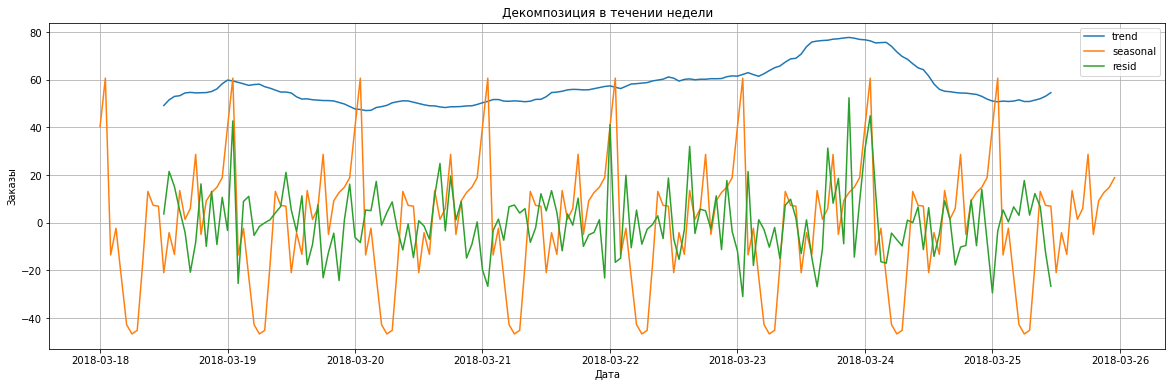

In [43]:
plt.figure(figsize=(20,6))
plt.plot(df_decomp, label=df_decomp.columns)
plt.title('Декомпозиция в течении недели')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid()
plt.legend();

Видим что сезонность улавливается в течении дня, тоесть день в день пики роста и падения повторяются

Построим график декомпозиции на всем доступном интервале данных на дневном интервале

In [44]:
decomposed = seasonal_decompose(df['num_orders'].resample('1d').sum())
df_decomp = pd.DataFrame()
df_decomp['trend'] = decomposed.trend
df_decomp['seasonal'] = decomposed.seasonal
df_decomp['resid'] = decomposed.resid

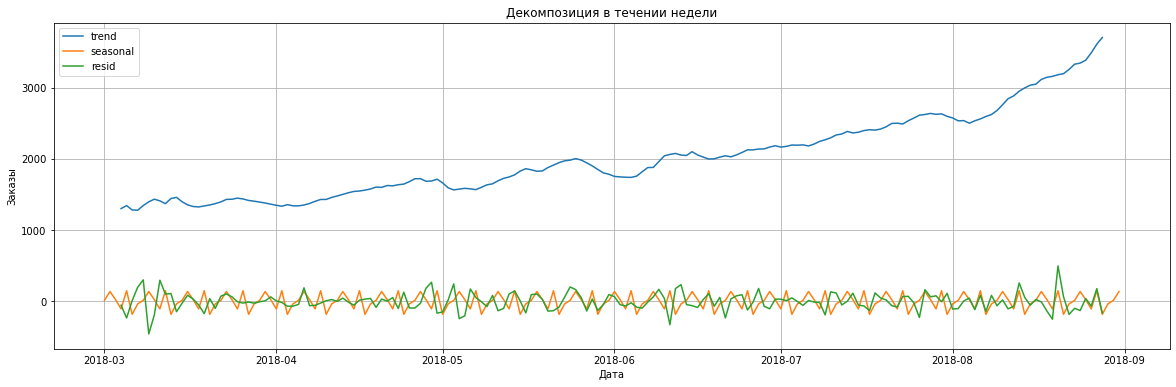

In [45]:
plt.figure(figsize=(20,6))
plt.plot(df_decomp, label=df_decomp.columns)
plt.title('Декомпозиция в течении недели')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid()
plt.legend();

Прослеживается тренд с равномерным ростом от марта до августа, и в августе значительный рост числа поездок. Для определения сезонности на годовом графике необходимо данные за несколько лет

Тренд всетаки наблюдается. Возможно на фоне дневных колебаний для тест он не заметен

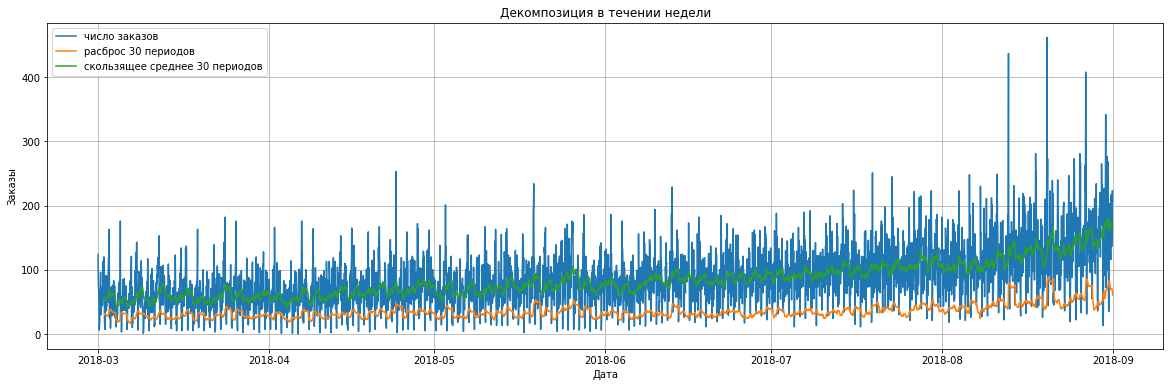

In [56]:
plt.figure(figsize=(20,6))
plt.plot(df['num_orders'], label='число заказов')
plt.plot(df['num_orders'].rolling(30).std(), label='расброс 30 периодов')
plt.plot(df['num_orders'].rolling(30).mean(), label='скользящее среднее 30 периодов')
plt.title('Декомпозиция в течении недели')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid()
plt.legend();

Видно что в конце периода разброс количества заказов значительно растет, как и их среднее количество

Построим график автокорреляции

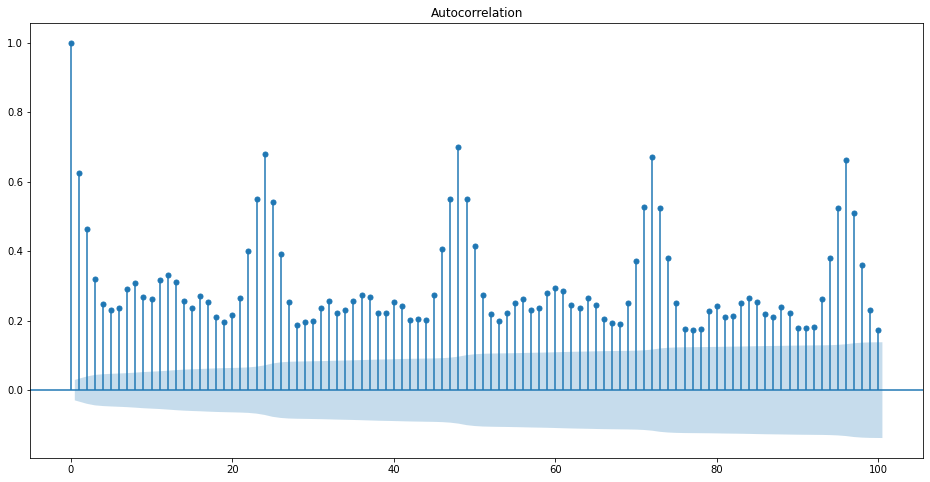

In [57]:
fig = plot_acf(df['num_orders'], lags=100)
fig.set_size_inches(16, 8)
plt.show()

На графике автокорреляции видно что данные коррелируют  с частотой в 24 часа, тоесть ежедневно картина заказов примерно повторяется

Напишем функцию для генерации новых признаков

In [58]:
def make_features(data, max_lag=6, 
                  step_lag=1, 
                  rolling_mean_fast=5, 
                  rolling_mean_slow=24, 
                  rolling_min_max_size=12):
    """Generate new features for timeseries df.

    Keyword arguments:
    data -- pandas.DataFrame
    max_lag -- max lag, start from 2 because using diff (default 6)
    step_lag -- step for lag (default 2)
    rolling_mean_fast -- rolling mean length (default 5)
    rolling_mean_slow -- rolling mean length (default 24)
    rolling_min_max_size -- rolling min and max (default 12)
    """
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(2, max_lag, step_lag):
        data['lag_' + str(lag)] = data.iloc[:, [0]].shift(lag)
    data['lag_24h'] = data.iloc[:, [0]].shift(24)
    data['std'] = data.iloc[:, [0]].rolling(rolling_mean_fast).std()
    data['rolling_mean_fast'] = data.iloc[:, [0]].shift(1).rolling(rolling_mean_fast).mean()
    data['rolling_mean_slow'] = data.iloc[:, [0]].shift(1).rolling(rolling_mean_slow).mean()
    data['rolling_max'] = data.iloc[:, [0]].shift(1).rolling(rolling_min_max_size).max()
    data['rolling_min'] = data.iloc[:, [0]].shift(1).rolling(rolling_min_max_size).min()
    data['diff'] = data.iloc[:, [0]].diff()

In [59]:
make_features(df)
df = df.dropna()

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_orders         4392 non-null   int64  
 1   hour               4392 non-null   int64  
 2   day                4392 non-null   int64  
 3   dayofweek          4392 non-null   int64  
 4   lag_2              4392 non-null   float64
 5   lag_3              4392 non-null   float64
 6   lag_4              4392 non-null   float64
 7   lag_5              4392 non-null   float64
 8   lag_24h            4392 non-null   float64
 9   std                4392 non-null   float64
 10  rolling_mean_fast  4392 non-null   float64
 11  rolling_mean_slow  4392 non-null   float64
 12  rolling_max        4392 non-null   float64
 13  rolling_min        4392 non-null   float64
 14  diff               4392 non-null   float64
dtypes: float64(11), int64(4)
mem

Построим матрицу корреляций

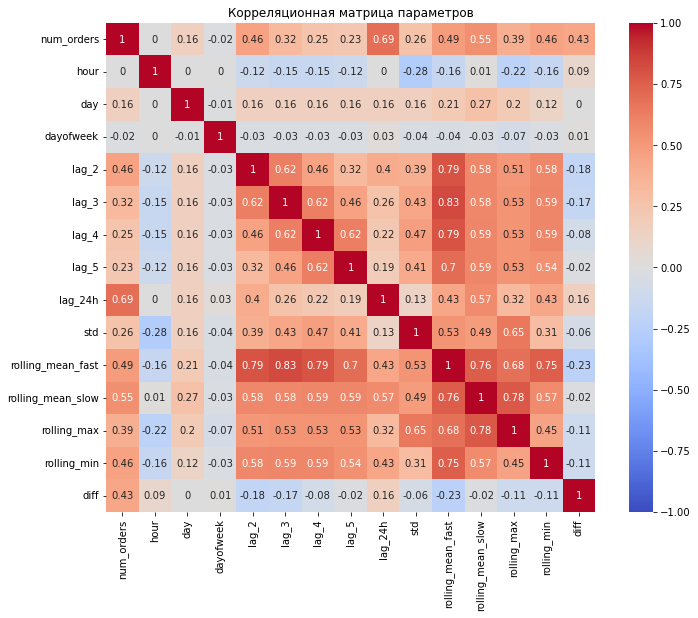

In [68]:
plt.figure(figsize=(12,9))
plt.title('Корреляционная матрица параметров')
sns.heatmap(df.corr().round(2), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True);

Отфильтруем мультиколлинеарные признаки

In [69]:
corr_feat = set()
corr_matrix = df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)
corr_feat

{'rolling_mean_fast'}

In [70]:
df = df.drop(corr_feat, axis=1)

**Вывод**

В данном разделе мы провели анализ и предобработку данных. Проверили на уникальность и мнотонность - оба результата положительны. Преобразовали данные из десятиминутного в часовой интервал. 

Проверили временной ряд на стационарность с помощью теста Дики — Фуллера. Результат теста ряд стационарен хотя визуально можно наблюдать тренд, что может сказаться на качестве предсказания. Поэтому при создании новых признаков добавим diff, разницу между предыдущим и текущим значением. Также добаим lag_24 - лаг с разницей 24 часа, так обнаруженная нами сезонность ряда соответствует 24 часам.

С помощью матрицы корреляции избаились от мультиколлинеарности признаков.
Данные подготовлены к обучению модели

## Обучение

Проведем разбиение выборки на обучающую и тестовую

In [71]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

Обучающая выборка:
Доля от общего размера: 0.9
Cтрок, столбцов: (3952, 13)
Доля целевого признака: 78.451
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.1
Cтрок, столбцов: (440, 13)
Доля целевого признака: 139.561
------------------------------


Для исключения утечки данных будем использовать TimeSeriesSplit, для последовательного разделения данных при кроссвалидации

In [75]:
tts = TimeSeriesSplit(n_splits=9)

pipe = Pipeline(
    [
        ("regressor", CatBoostRegressor())
    ]
)

param_grid = [
    {
        'regressor': [CatBoostRegressor(random_state=47, 
                                        eval_metric='RMSE', 
                                        silent=True, 
                                        early_stopping_rounds=10)],
        'regressor__depth': range(2, 12, 2),
        'regressor__learning_rate': np.linspace(0.3, 0.9, 7),
        'regressor__iterations': range(50,500,50)
    },
    {
        'regressor': [Ridge(random_state=47)],
        'regressor__alpha': [0.5, 1, 3, 5],
        'regressor__tol': [0.00001, 0.0001, 0.001],
        'regressor__max_iter': [4000, 8000, 10000],
        'regressor__solver': ['auto', 'cholesky', 'lsqr']
    },
]

grid = RandomizedSearchCV(pipe, param_grid, 
                          n_iter=50 ,
                          cv=tts, 
                          scoring = 'neg_mean_squared_error', 
                          verbose=3)

Pipeline подготовлен проведем обучение модели

In [76]:
%%time
grid.fit(X_train, y_train)

Fitting 9 folds for each of 50 candidates, totalling 450 fits
[CV 1/9] END regressor=<catboost.core.CatBoostRegressor object at 0x000001446A400550>, regressor__depth=2, regressor__iterations=150, regressor__learning_rate=0.9;, score=-322.846 total time=   0.0s
[CV 2/9] END regressor=<catboost.core.CatBoostRegressor object at 0x000001446A400550>, regressor__depth=2, regressor__iterations=150, regressor__learning_rate=0.9;, score=-243.894 total time=   0.0s
[CV 3/9] END regressor=<catboost.core.CatBoostRegressor object at 0x000001446A400550>, regressor__depth=2, regressor__iterations=150, regressor__learning_rate=0.9;, score=-293.375 total time=   0.1s
[CV 4/9] END regressor=<catboost.core.CatBoostRegressor object at 0x000001446A400550>, regressor__depth=2, regressor__iterations=150, regressor__learning_rate=0.9;, score=-304.969 total time=   0.0s
[CV 5/9] END regressor=<catboost.core.CatBoostRegressor object at 0x000001446A400550>, regressor__depth=2, regressor__iterations=150, regresso

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
                   estimator=Pipeline(steps=[('regressor',
                                              <catboost.core.CatBoostRegressor object at 0x000001446A400E20>)]),
                   n_iter=50,
                   param_distributions=[{'regressor': [<catboost.core.CatBoostRegressor object at 0x000001446A400550>],
                                         'regressor__depth': range(2, 12, 2),
                                         'regressor__iterations': range(50, 500, 50),
                                         'regressor__learning_rate': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                                        {'regressor': [Ridge(random_state=47)],
                                         'regressor__alpha': [0.5, 1, 3, 5],
                                         'regressor__max_iter': [4000, 8000,
                                                                 10000]

Посмотрим на лучшую получившуюся модель 

In [77]:
grid.best_estimator_

Pipeline(steps=[('regressor',
                 <catboost.core.CatBoostRegressor object at 0x000001446086E100>)])

In [78]:
result = pd.DataFrame(grid.cv_results_)
result['mean_test_score'] = (result['mean_test_score']*-1)**0.5
result.sort_values('mean_test_score')[['mean_fit_time', 
                                       'std_fit_time',
                                       'mean_score_time', 
                                       'param_regressor', 
                                       'mean_test_score']].head()

,mean_fit_time,std_fit_time,mean_score_time,param_regressor,mean_test_score
37,0.520460,0.080285,0.002562,<catboost.core.CatBoostRegressor object at 0x0...,16.355585
21,0.258188,0.043894,0.002596,<catboost.core.CatBoostRegressor object at 0x0...,16.727596
12,0.172015,0.028844,0.002731,<catboost.core.CatBoostRegressor object at 0x0...,16.743159
33,0.211841,0.034783,0.002701,<catboost.core.CatBoostRegressor object at 0x0...,16.838448
46,0.124154,0.017918,0.002652,<catboost.core.CatBoostRegressor object at 0x0...,16.871128


Проведем оценку важности признаков с помощью Shap

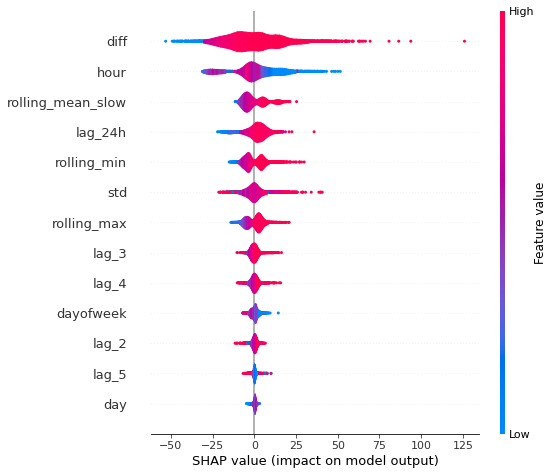

In [79]:
explainer = shap.TreeExplainer(grid.best_estimator_.named_steps["regressor"])
shap_values = explainer.shap_values(X_train, y=y_train.values)
shap.summary_plot(shap_values, X_train, plot_type="violin")

**Вывод**
В данном разделе проведено обучение двух моделей с подбором гиперпараметров. Лучший результат показал CatBoostRegressor. Наиболее важными признками являются разница diff, час hour.

Лучшая модель выбрана, испытаем ее на тестовой выборке

## Тестирование

In [80]:
y_val = grid.best_estimator_.predict(X_test)
test_val = mean_squared_error(y_test, y_val, squared=False)
print('RMSE работы модели на тестовой выборке:', round(test_val, 2))

RMSE работы модели на тестовой выборке: 29.75


In [81]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print("Средний объём заказов в час:", round(y_test.mean(), 2))
print("RMSE с заполнением предыдущим:",  round(mean_squared_error(y_test, 
                                                                 pred_previous, 
                                                                 squared=False), 2))

Средний объём заказов в час: 139.56
RMSE с заполнением предыдущим: 58.88


In [82]:
print("Разница RMSE результата модели и при заполнением предыдущим значением:",
            round(mean_squared_error(y_test, pred_previous, squared=False), 2) -
            round(test_val, 2))

Разница RMSE результата модели и при заполнением предыдущим значением: 29.130000000000003


Модель показывает результат гораздо лучше 

Сравним результат работы модели и теста

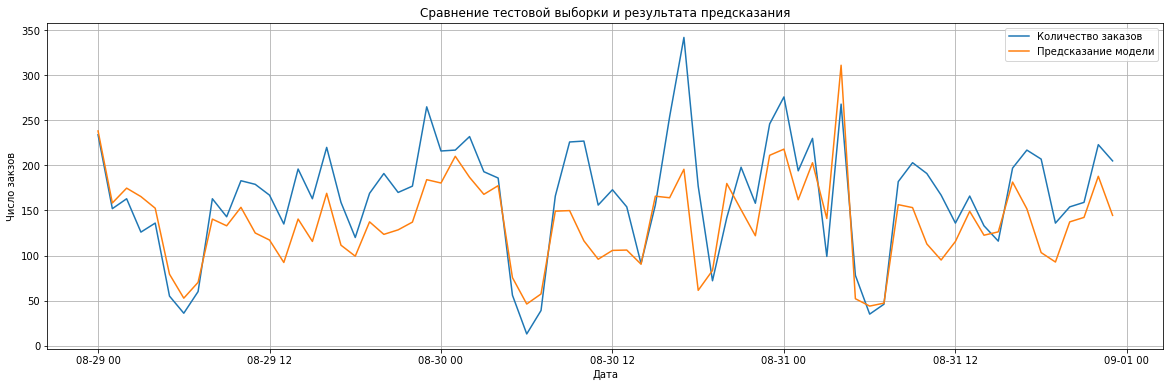

In [90]:
final_result = pd.DataFrame(y_test)
final_result['pred'] = y_val

plt.figure(figsize=(20,6))
plt.plot(
    final_result.loc['2018-08-29':'2018-08-31'], 
    label=['Количество заказов', 'Предсказание модели']
    )
plt.title('Сравнение тестовой выборки и результата предсказания')
plt.xlabel('Дата')
plt.ylabel('Число закзов')
plt.grid()
plt.legend();

В целом немного запаздывает, но значения расположены довольно близко, за исключением нескоторых экстремальных значений

**Вывод**

В данной работе нами проведено исследование данных заказов такси из аэропорта, для предсказания нагрузки на следбующий час.
 
При подготовке данных мы преобразовали данные в часовой интервал. Проверили данные на монотонность и уникальность значения для исключения пропусков и дубликатов.

Проверили данные на сезонность и тренд. Хотя некоторый тренд прослеживается, тест Дики-Фуллера показал что ряд стационарен. 

Установили с помощью графика автокорреляции что данные "повторяются с интервалом 24часа.

Подготовили новые признаки, такие как месяц, год - отбросили так как он один и тот же, день в месяце, день недели, лаг с отставанием от 2-5, 24 часовой лаг, стандартное отклонение, скользящее среднее, минимум и максимум за период, и разницу с предыдущим значением diff.

Проверили и удалили столбцы с мультиколлинеарными признаками.

Обучение и подбор гиперпараметров провели для двух моделей CatBoostRegressor и Ridge, с помощью pipeline с TimeSeriesSplit для предотвращения утечки при кроссвалидации.

In [32]:
print('RMSE работы модели на тестовой выборке:', round(test_val, 2))

RMSE работы модели на тестовой выборке: 30.91


Для целей предсказания нагрузки рекомендуется использовать модель CatBoostRegressor со следующими гиперпараметрами

In [33]:
grid.best_estimator_.named_steps["regressor"].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 10,
 'random_seed': 47,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.300000011